In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import tensorflow_text as text
from official.nlp import optimization #AdamW optimizer
import re    #for regex
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tensorflow import keras
import re    #for regex
import nltk
from sklearn.model_selection import train_test_split


In [3]:
pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.2 MB/s 


In [4]:
pip install tf-models-official

     |████████████████████████████████| 1.8 MB 5.4 MB/s 
     |████████████████████████████████| 47.6 MB 60.0 MB/s 
     |████████████████████████████████| 352 kB 47.9 MB/s 
     |████████████████████████████████| 90 kB 8.5 MB/s 
     |████████████████████████████████| 1.2 MB 32.5 MB/s 
     |████████████████████████████████| 213 kB 47.0 MB/s 
     |████████████████████████████████| 596 kB 42.2 MB/s 
     |████████████████████████████████| 43 kB 2.0 MB/s 
     |████████████████████████████████| 99 kB 2.9 MB/s 
     |████████████████████████████████| 1.1 MB 46.9 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=cb99e4a7ecbf39714e34170441c82c827a7f8a70140f82ae52e9ddc2532433b1
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=115095aaf23e43a09bae3835f3dd138a09847af0777ef437730a337c87607df8
  Stored 

In [6]:
train = pd.read_csv('/content/drive/MyDrive/toxic_5.csv')

In [ ]:
train

,Unnamed: 0,comment_text,Toxic
0,61,Discussion requires both parties to explain th...,0
1,40630,"Avoiding Edit Wars \n\nAcroterion, I have been...",0
2,12124,omg I've never thought of it that way. pure ge...,0
3,11380,"Because of our recent edits to SkyCable, the u...",0
4,5844,No harm done i deleted the second comment,0
...,...,...,...
41034,43459,new mutants putlocker” about to be the #1 goog...,1
41035,43460,It was better than the New Mutants. There were...,1
41036,43461,Whenever I THINK that I’m TRULY Fast & Furious...,1
41037,43462,My man wasn't to happy I left on this Harley D...,1


In [7]:
train['comment_text'] = pd.DataFrame(train["comment_text"].astype('str')) 

In [10]:


import re
!pip install contractions
import contractions


i=0
for doc in train.comment_text:
    doc = doc.lower()
    doc=  re.sub(r"https?://\S+|www\.\S+",'', doc)  #Remove URLs from a sample string
    doc = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', '', doc) # clean url
    doc = re.sub(r'#(\w+)', '',doc)   # clean hashes
    doc = re.sub(r'[^\x00-\x7f]',r'', doc) #Remove non-ASCII characters 
    doc = re.sub(r'@(\w+)', '', doc)   # clean @
    doc = re.sub(r'<[^>]+>', '',doc)  # clean tags
    doc = re.sub(r'\d+', '',doc)      # clean digits
    doc=re.sub(r'<.*?>','',doc)
    doc = re.sub("#", " ",doc)
    doc = re.sub(":::", " ", doc)
    doc = re.sub("\n", " ",doc)
    doc=re.sub(r'[^a-zA-Z\s]','',doc,re.I|re.A)
    punctuation = set(string.punctuation)  #remove the punctuation
    doc = "".join([p for p in doc if p not in punctuation])
    doc=contractions.fix(doc)
    train.comment_text[i]=doc
    i+=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
train

,Unnamed: 0,comment_text,Toxic
0,61,discussion requires both parties to explain th...,0
1,40630,avoiding edit wars acroterion i have been tr...,0
2,12124,omg i have never thought of it that way pure g...,0
3,11380,because of our recent edits to skycable the us...,0
4,5844,no harm done i deleted the second comment,0
...,...,...,...
41034,43459,new mutants putlocker about to be the google ...,1
41035,43460,it was better than the new mutants there were ...,1
41036,43461,whenever i think that i am truly fast furious...,1
41037,43462,my man was not to happy i left on this harley ...,1


In [ ]:
doc

'got worn fuck exhausting threesome muscle falling body like metal fast furious car going damn fast'

In [ ]:
x=train["comment_text"]
y=train["Toxic"]

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(x,y, test_size=0.2, random_state=1,shuffle=True)

In [ ]:
tfhub_encoder = "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1"
tfhub_preprocession = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
def build_bert_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string,name='text_input')
    pre_processing_layer = hub.KerasLayer(tfhub_preprocession,name='pre_processing')
    encoder_inputs = pre_processing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_encoder,trainable=True,name='bert_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='bert_classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
classifier_model = build_bert_model()



In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [ ]:
epochs = 10
steps_per_epoch = 500
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 4e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:

classifier_model.compile(optimizer=optimizer,loss=loss,metrics=metrics)

In [ ]:
callback=keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=0, patience=4, verbose=2, mode='auto', restore_best_weights=True)
history = classifier_model.fit(x=train_x,y=train_y,
                               validation_split=0.1,shuffle=True,
                               epochs=epochs,callbacks=[callback])

Epoch 1/10
924/924 [==============================] - 401s 423ms/step - loss: 0.2744 - binary_accuracy: 0.8763 - val_loss: 0.1840 - val_binary_accuracy: 0.9281
Epoch 2/10
924/924 [==============================] - 390s 422ms/step - loss: 0.1516 - binary_accuracy: 0.9428 - val_loss: 0.1925 - val_binary_accuracy: 0.9333
Epoch 3/10
924/924 [==============================] - 392s 424ms/step - loss: 0.1048 - binary_accuracy: 0.9633 - val_loss: 0.2117 - val_binary_accuracy: 0.9272
Epoch 4/10
924/924 [==============================] - 392s 424ms/step - loss: 0.0683 - binary_accuracy: 0.9786 - val_loss: 0.2760 - val_binary_accuracy: 0.9306
Epoch 5/10
924/924 [==============================] - 388s 420ms/step - loss: 0.0458 - binary_accuracy: 0.9863 - val_loss: 0.3524 - val_binary_accuracy: 0.9309
Epoch 00005: early stopping


In [ ]:
classifier_model.save('bert_model')

INFO:tensorflow:Assets written to: bert_model/assets


INFO:tensorflow:Assets written to: bert_model/assets


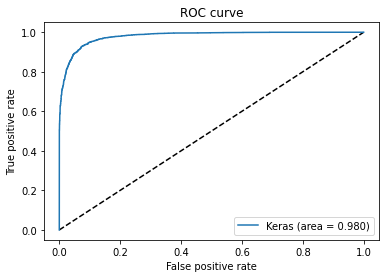

In [ ]:
from sklearn.metrics import roc_curve
y_pred=tf.sigmoid(classifier_model.predict(test_x))
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
from sklearn.metrics import auc
auc_keras = auc(fpr, tpr)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import classification_report
fpr, tpr, thresholds = roc_curve(test_y, y_pred)
RightIndex=(tpr-fpr)
index=np.where(RightIndex==max(RightIndex))#Youden_index

best_threshold=thresholds[index]

print("The best threshold is",best_threshold)
print(classification_report(test_y, y_pred>best_threshold ,digits=4))

The best threshold is [0.54045373]
              precision    recall  f1-score   support

           0     0.9327    0.9256    0.9291      4234
           1     0.9214    0.9288    0.9251      3974

    accuracy                         0.9271      8208
   macro avg     0.9270    0.9272    0.9271      8208
weighted avg     0.9272    0.9271    0.9272      8208



In [ ]:
def Find_Optimal_Cutoff(TPR, FPR, threshold):
    y = TPR - FPR
    Youden_index = np.argmax(y)  # Only the first occurrence is returned.
    optimal_threshold = threshold[Youden_index]
    point = [FPR[Youden_index], TPR[Youden_index]]
    return optimal_threshold, point

In [ ]:
def ROC(label, y_prob):

    fpr, tpr, thresholds = roc_curve(label, y_prob)
    roc_auc = auc(fpr, tpr)
    optimal_th, optimal_point = Find_Optimal_Cutoff(TPR=tpr, FPR=fpr, threshold=thresholds)
    return fpr, tpr, roc_auc, optimal_th, optimal_point

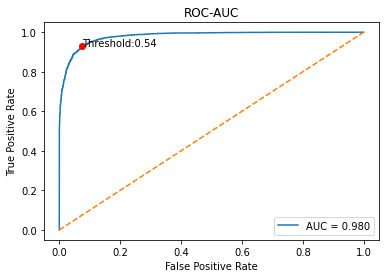

In [ ]:
fpr, tpr, roc_auc, optimal_th, optimal_point = ROC(test_y,y_pred)
 
plt.figure(1)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.plot(optimal_point[0], optimal_point[1], marker='o', color='r')
plt.text(optimal_point[0], optimal_point[1], f'Threshold:{optimal_th:.2f}')
plt.title("ROC-AUC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
sample_text=["There seems to be quite a bit of agreement on what Im about to say about the film. Venom doesnt quite know what it is. It cant decide wether its a goofy, action or a horror movie. Therefore its all of it and none at the same time. The goofy jokes are pretty lame, which is why they are funny, you dont laugh with the writers, you laugh at them. The action scenes are meh at best, car chase : check motorcycle : check ridiculous (bad) cgi fight: check sure, watching Tom Hardy motorcross in San Francisco is quite fun, but its not really action. Finally, the horror; there are glimpses, glimmers of hope scattered around this movie. Little snippets of what could have been, but as soon as they appear they disappear. Two scenes really stood out to me due to their potential. After quite a lot of buildup of Venom getting into the building (BY RUNNING UP IT), Eddie decides to take the lift down. Instead of having Eddie walk into the SWAT team, they should have been swarming the building crawling through the floors looking for him. Then, they could have had an ALIEN like hunting scene where Venom slowly takes out the task force one by one, in true horror movie fashion. The other obvious horror scene could have been using the creepy little girl that delivers RIOT to the Musk wannabe, they could have homaged The Shining, they could have pulled an exorcist, they could have done a million things, but the little girl just has white pupils and a deep voice. Throughout the movie there are just continuous disappointments because you see what it is missing. Instead of the cheap love story and all the stupid overdone things they should have been ballsy with their movie. Yes the movie DID make 800+ million, however im sure it was going to do that anyway. Venom is probably one of the most badass characters in comic history, and Tom Hardy is Tom Hardy. I would have loved to see something along these lines: Symbiote hunts Eddie. Symbiote captures Eddie and they become Venom. Venom starts unleashing hell because he can, hunts SWAT etc. Venom goes after Musk wannabe and Kills him. Throw some more horror elements in there, and it would have made for a much more satisfactory watch. I have always adored Venom, and this movie had so much potential, but it was all for nothing. No rewatchability. Nothing worth remembering. Just a flick. It was funny seeing Tom Hardy being a bit of a pussball, but even he cant help a crap script and an even worse film."]

In [ ]:
sample_text=["I enjoyed watching the movie, but it is obvious from its name and poster that it is a terrible movie. I don't regret watching :)"]

In [ ]:
sample_text=["Started Binging to Catch up and WOW what a PIECE OF CRAP"]

In [ ]:
predictions =classifier_model.predict(sample_text) 

In [ ]:
tf.sigmoid(predictions)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0403482]], dtype=float32)>